# keras实战笔记1: 使用DNN学习Fashion MNIST dataset

本节内容：
- 密集神经网络 DNN(Deep neural network)
- K折交叉验证 K-fold cross-validation
- 手动的超参数优化
- 一些防止过拟合的方法：
  - L2 正则化 (L2 regularization)
  - Dropout
  - （虚假的） Early stopping

相关文档：
- [Keras](https://keras.io/)
- [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist)  
  
  
在 Google Colab 中运行，需要将 TensorFlow 版本设置为2.0:

In [0]:
import sys
sys.path[0] = '/tensorflow-2.1.0/python3.6' # 添加系统变量

In [0]:
from distutils.version import StrictVersion
import tensorflow
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math

assert StrictVersion(tensorflow.__version__) >= StrictVersion('2.0')

## 1. 导入数据集

In [0]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

数据以 NumPy 数组的形式保存。

训练集 `train_images` 共有 60000 个图像，测试集 `test_images` 共有10000个图像，图像为 28 * 28 像素的灰度图。

In [4]:
print('The type of train_images is', type(train_images))
print('The type of train_labels is', type(train_labels))
print()
print('train_images.shape =', train_images.shape)
print('train_labels.shape =', train_labels.shape)
print('test_images.shape =', test_images.shape)
print('test_labels.shape =', test_labels.shape)

The type of train_images is <class 'numpy.ndarray'>
The type of train_labels is <class 'numpy.ndarray'>

train_images.shape = (60000, 28, 28)
train_labels.shape = (60000,)
test_images.shape = (10000, 28, 28)
test_labels.shape = (10000,)


其中每个图像的标签是范围在 0～9 的整数，以 NumPy 数组保存。为了方便，定义一个字典 `labels_dict` 以查找标签对应的衣服类型。

In [5]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [0]:
labels_dict = { 0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

对每个类别，找到一个图像作可视化：

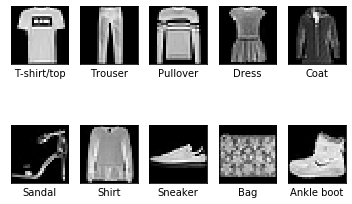

In [7]:
nrows = 2
ncols = math.ceil(len(labels_dict)//2)

plt.figure()
for i in range(len(labels_dict)): # 遍历所有类别
    for j in range(len(train_images)): # 遍历测试集，找到符合第i个类别的图像
        if train_labels[j] == i:
            plt.subplot(nrows, ncols, i + 1)
            plt.xticks([]) # 禁用 X 轴坐标轴刻度
            plt.yticks([]) # 禁用 Y 轴坐标轴刻度
            plt.grid(False) # 禁用网格，这里其实没有必要，因为已经没有刻度了。
            plt.imshow(train_images[j], cmap=plt.cm.gray)
            plt.xlabel(labels_dict[i])
            break
plt.show()

## 2. 数据集预处理

因为数据已经是张量的形式，所以无需再次数据张量化。

为了方便训练神经网络，使用数据归一化 (Normalization)：

In [0]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') /255

## 3. 构建并评估模型
#### 3.1 基于常识的简单基准方法  
一个基于常识的简单基准方法是随机数：这样的准确率是1/10，即10%。  

#### 3.2 密集连接网络
#### 3.2.1 第一个模型
- 输入层：因为每个图像都是二维张量的形式，进入 `Dense` 层之前需要将数据展平为一维张量（向量）的形式。可以使用两种方法：  
  1. 使用 `Flatten`层  
  2. 使用 `numpy.ndarray.reshape()` 方法预处理数据  
  
  这里使用第一种方法。  
- 中间层： 一个或两个 `Dense` 层，使用 `relu` 函数激活。  
- 输出层：输出10个概率，对应10个类别，概率总和为1。所以最后一层是10路由 `softmax` 函数激活的 `Dense` 层。  
- 优化器：adam（Adaptive Moment Estimation) 似乎是当前最先进的优化器。  
- 损失函数：由于目标是整数标量编码，所以使用 sparse_categorical_crossentropy。 [与categorical_crossentropy的区别](https://jovianlin.io/cat-crossentropy-vs-sparse-cat-crossentropy/)  
- 评估标准：本例只关心精度，即正确分类的图像所占的比例。 

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models

def build_model(middle_units_1=0, regularizer_1=None, dropout_1=0, 
                middle_units_2=0, regularizer_2=None, dropout_2=0, 
                summary=False):
  model = models.Sequential()

  # 输入层
  model.add(layers.Flatten(input_shape=(28, 28))) 

  # 第一个中间层
  if middle_units_1:
    model.add(layers.Dense(middle_units_1, activation='relu', kernel_regularizer=regularizer_1)) 
  if dropout_1:
    model.add(layers.Dropout(dropout_1))

  # 第二个中间层
  if middle_units_2:
    model.add(layers.Dense(middle_units_2, activation='relu', kernel_regularizer=regularizer_2))
  if dropout_2:
    model.add(layers.Dropout(dropout_2))

  # 输出层
  model.add(layers.Dense(10, activation='softmax')) 
  
  if summary:
    model.summary()
  model.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

由于测试集只有60000个，为了避免样本噪声 (sampling noise)，使用**K折交叉验证** (K-fold cross validation)

In [0]:
def k_fold_val(k, data, labels, 
               middle_units_1=0, regularizer_1=None, dropout_1=0, 
               middle_units_2=0, regularizer_2=None, dropout_2=0, 
               epochs=10):
  assert len(data) == len(labels)

  len_per_fold = len(data) // k
  histories = []

  for i in range(k):

    # data split
    print('Iteration:',i+1,'/',k)
    val_data = data[i*len_per_fold: (i+1)*len_per_fold]
    val_labels = labels[i*len_per_fold: (i+1)*len_per_fold]
    train_data = np.concatenate((data[: i * len_per_fold], data[(i + 1) * len_per_fold: ]))
    train_labels = np.concatenate((labels[: i * len_per_fold], labels[(i + 1) * len_per_fold: ]))

    # build model
    model = build_model(middle_units_1, regularizer_1, dropout_1, 
                        middle_units_2, regularizer_2, dropout_2)
    histories.append(model.fit(train_data, train_labels, epochs=epochs, batch_size=128, 
                                 validation_data=(val_data, val_labels), verbose=0))

  return histories

为了方便训练结果的可视化，定义函数 `visualize()` ，它同时包含了通过 `val_loss` 的变化判断过拟合的功能。[（为什么？）](https://blog.csdn.net/quiet_girl/article/details/86138489)

In [0]:
def visualize(histories):

  accuracy = []
  val_accuracy = []
  loss = []
  val_loss = []

  for history in histories:
    accuracy.append(history.history['accuracy'])
    val_accuracy.append(history.history['val_accuracy'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
  
  accuracy = np.mean(accuracy, axis=0)
  val_accuracy = np.mean(val_accuracy, axis=0)
  loss = np.mean(loss, axis=0)
  val_loss = np.mean(val_loss, axis=0)
  epochs = range(1, len(loss) + 1)
  
  # 暂时没有找到对 k-fold 的 Early stopping 的方法，只好手动了。
  # 如果在一轮后的10轮内，val_loss不再下降，给出 Overfitting warning
  x = []
  y = []
  patience = 10
  i = 0
  for i in range(len(val_loss) - patience):
    flag = True
    for j in range(1, patience + 1):
      if val_loss[i] * 0.98 > val_loss[i + j]: # 在之后的10轮中，下降不超过2%，视为过拟合
        flag = False
        break 
    if flag ==True:
      x.append(i + 1)
      y.append(val_loss[i])
      print('Overfitting warning at epoch %d, val_loss: %.3f, val_accuracy: %.3f' % (i+1, val_loss[i], val_accuracy[i]))  
      break

  plt.figure(figsize=(12, 4))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, 'o', label = 'loss')
  plt.plot(epochs,val_loss, label = 'val_loss')
  plt.scatter(x,y,c='r')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, 'o', label = 'accuracy')
  plt.plot(epochs,val_accuracy, label = 'val_accuracy')
  plt.scatter(x, [val_accuracy[x[0]-1]], c='r')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  plt.show()

先使用一层中间层，隐藏单元64个。训练40次

Iteration: 1 / 5
Iteration: 2 / 5
Iteration: 3 / 5
Iteration: 4 / 5
Iteration: 5 / 5
Overfitting warning at epoch 15, val_loss: 0.329, val_accuracy: 0.883


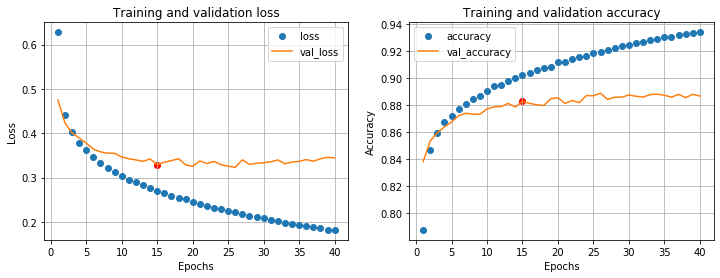

In [14]:
k = 5
visualize(k_fold_val(k, train_images, train_labels, middle_units_1=64, epochs=40))

从第18轮后开始，`val_loss`不再下降，模型过拟合。这个模型在验证集上的最终精度是88.3%，精确度能不能再提高？

#### 3.2.2 使用正则化降低拟合速度  
增加L2正则化。

Iteration: 1 / 5
Iteration: 2 / 5
Iteration: 3 / 5
Iteration: 4 / 5
Iteration: 5 / 5
Overfitting warning at epoch 24, val_loss: 0.391, val_accuracy: 0.879


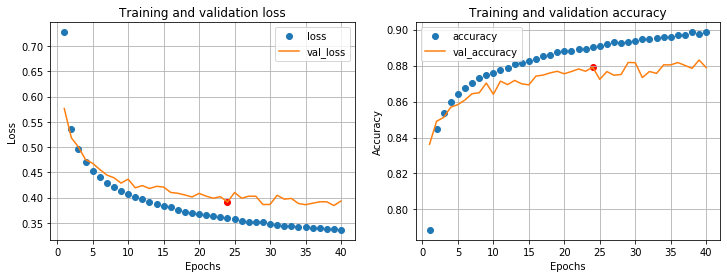

In [15]:
visualize(k_fold_val(k, train_images, train_labels, middle_units_1=64, regularizer_1=keras.regularizers.l2(0.001), epochs=40))

可以看到模型在第24轮后过拟合。过拟合明显变慢。在验证集上的精度是87.9%

再试试使用 Dropout 正则化, Dropout 比率0.2：

Iteration: 1 / 5
Iteration: 2 / 5
Iteration: 3 / 5
Iteration: 4 / 5
Iteration: 5 / 5
Overfitting warning at epoch 15, val_loss: 0.319, val_accuracy: 0.885


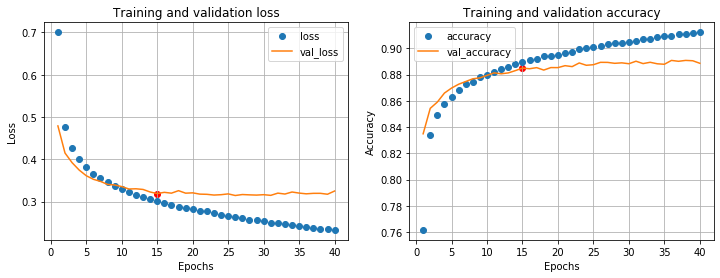

In [16]:
visualize(k_fold_val(k, train_images, train_labels, middle_units_1=64, dropout_1=0.2, epochs=40))

模型在第15轮后过拟合，过拟合速度并没有减慢。是因为 dropout 比率太小的原因吗？把 Dropout 比率提高到0.4:

Iteration: 1 / 5
Iteration: 2 / 5
Iteration: 3 / 5
Iteration: 4 / 5
Iteration: 5 / 5
Overfitting warning at epoch 20, val_loss: 0.334, val_accuracy: 0.880


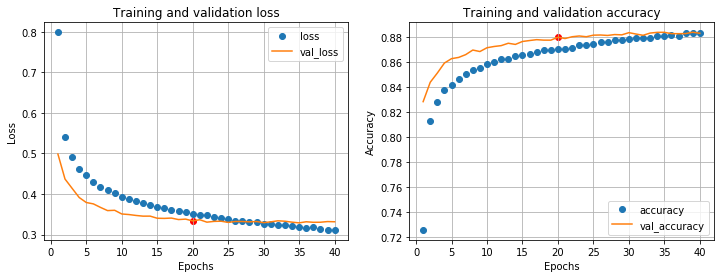

In [19]:
visualize(k_fold_val(k, train_images, train_labels, middle_units_1=64, dropout_1=0.4, epochs=40))

模型过拟合的速度慢了，可是验证集精度没有上升。
#### 小结：
1. L2 正则化和 Dropout 都可以减慢拟合速度。参数越大，拟合越慢。
2. L2 正则化和 Dropout 都没有带来更好的精度。原因可能是神经网络太小，需要增加神经网络隐藏单元或者层数。
3. 使用 Dropout 后，开始阶段验证集的精度比训练集好，这是因为只有在训练集上 Dropout 层起作用，在验证集上不经过 Dropout 层。

#### 3.2.3 调节神经网络大小
在上面的例子中，精度仍然不够高。尝试增加一些隐藏单元到256个，同时保留 Dropout 层。

Iteration: 1 / 5
Iteration: 2 / 5
Iteration: 3 / 5
Iteration: 4 / 5
Iteration: 5 / 5
Overfitting warning at epoch 20, val_loss: 0.295, val_accuracy: 0.895


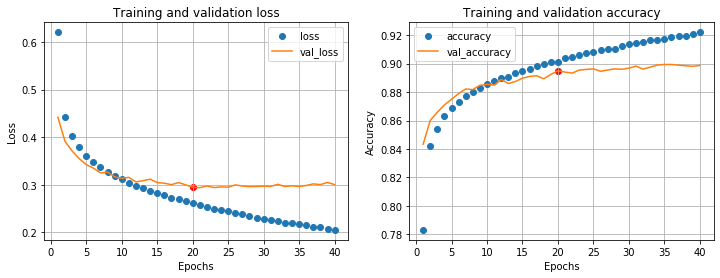

In [17]:
visualize(k_fold_val(k, train_images, train_labels, middle_units_1=256, dropout_1=0.4, epochs=40))

在验证集上的精度为89.5%，4倍的隐藏单元只带来了 1% 精度的提升。效果并不好。

再试试如果只增加一层中间层：

Iteration: 1 / 5
Iteration: 2 / 5
Iteration: 3 / 5
Iteration: 4 / 5
Iteration: 5 / 5
Overfitting warning at epoch 20, val_loss: 0.318, val_accuracy: 0.886


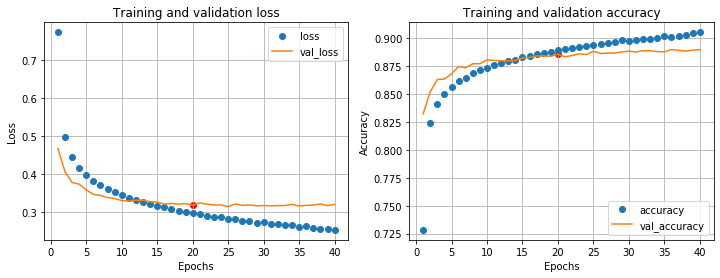

In [18]:
visualize(k_fold_val(k, train_images, train_labels, middle_units_1=64, dropout_1=0.2, middle_units_2=64, dropout_2=0.2, epochs=40))

效果也不好。两层各256个单元试试：

Iteration: 1 / 5
Iteration: 2 / 5
Iteration: 3 / 5
Iteration: 4 / 5
Iteration: 5 / 5
Overfitting warning at epoch 12, val_loss: 0.299, val_accuracy: 0.892


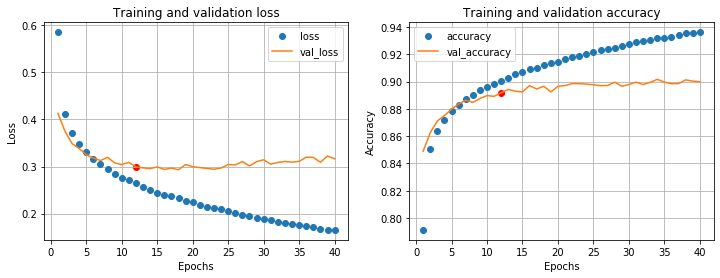

In [20]:
visualize(k_fold_val(k, train_images, train_labels, middle_units_1=256, dropout_1=0.2, middle_units_2=256, dropout_2=0.2, epochs=40))

#### 3.2.4 小结
| 编号 | 模型（中间层）| 验证集精度 |  
| :----: | ---- | :----: |
| 1 | dense(64) | 88.3% |  
| 2 | dense(64) with L2| 87.9%|  
| 3 | dense(64) with Dropout | 88.5% |  
| 4 | dense(256) with Dropout | 89.5% |  
| 5 | dense(64)-dense(64) with Dropout | 88.6% |  
| 6 | dense(256)-dense(256) with Dropout | 89.2% |  

无论怎样增大神经网络，验证集的精度都不会超过90%。选择表现最好的模型4在测试集上测试。

In [21]:
model = build_model(256, dropout_1=0.4, summary=True)
model.fit(train_images, train_labels, batch_size=128, epochs=20, verbose=0)
model.evaluate(test_images, test_labels)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_35 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 1s 66us/sample - loss: 0.3279 - accuracy: 0.8864


[0.3279034249544144, 0.8864]

在测试集上的精度 88.6% 和之前在交叉验证中的精确度 89.5% 相近。模型没有在交叉验证的验证集上过拟合。

### 3.3 第二类模型：卷积神经网络

对于计算机视觉问题，通常卷积神经网络会有更好的效果。  
2D卷积层 `Conv2D` 的输入是一个四维张量：`(batch, rows, cols, channels)`，所以需要将图像数据拓展一个维度。

In [0]:
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

这里只试验一个模型，不再调节超参数。(所以不需要分割出验证集，这里直接把测试集当作验证集了。）  
另外由于卷积网络的训练较为耗时，进行k折交叉验证还会增加k倍计算量，所以不进行交叉验证。

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_37 (Flatten)         (None, 576)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 576)             

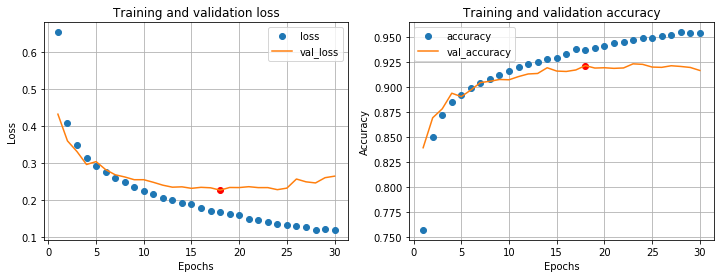

In [24]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=30, batch_size=128, 
                    validation_data=(test_images, test_labels), verbose=0)
visualize([history])

这个卷积神经网络的精度为92.1%，已经显著高于任何一个使用过的密集神经网络的例子。  
## 4. 总结
1. 在这个实践中没有考虑优化器、学习率和激活函数对神经网络造成的影响。
1. 通过正则化防止过拟合的方法在没有很快过拟合的神经网络上（似乎）并不能提高模型的性能。此时模型的性能瓶颈（可能）在模型架构、模型大小以及数据的特征提取上。
1. 验证集上的 loss 函数在接下来的几个 epoch 上不再减小 是判断是否过拟合的一个很好的方式。
1. 在计算机视觉问题上，卷积网络要比密集网络效果好。
2. 调节超参数耗时耗力，应当考虑搭配其他的机器学习库完成自动调整超参数。
这里引用 《Deep Learning with Python》(Francois_Chollet)中文版的一段话：
> 整天调节超参数不应该是人类的工作，最好留给机器去做。  
> 
> 超参数优化的过程[…]的关键在于，给定许多组超参数，使用验证性能的历史来选择下一组需要评估的超参数的算法。有多种不同的技术可供选择:贝叶斯优化、遗传算法、简单随机搜索等。
> 
> 这些挑战非常困难，而这个领域还很年轻，因此我们目前只能使用非常有限的工具来优化模型。通常情况下，随机搜索(随机选择需要评估的超参数，并重复这一过程)就是最好的 解决方案，虽然这也是最简单的解决方案。但我发现有一种工具确实比随机搜索更好，它就是 Hyperopt。它是一个用于超参数优化的Python 库，其内部使用 Parzen 估计器的树来预测哪组超 参数可能会得到好的结果。另一个叫作 Hyperas 的库将 Hyperopt 与 Keras 模型集成在一起。一定要试试。

3. 机器学习太费 GPU 了，这个 notebook 在 Google Colab 上大概要跑20分钟左右才能跑完。。但是又没有钱买 2080Ti，下次试试白嫖 kaggle 的 GPU 试试。